In [1]:
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# NN model, lunar lander environment, run the model
def run(model, env, n_sim):
    model.eval()
    
    all_rewards = np.zeros(n_sim)
    with torch.no_grad():
        for idx_sim in range(n_sim):
            observation, info = env.reset() # Reset environment
            terminated = False
            truncated = False
            while not terminated and not truncated:
                observation = torch.from_numpy(observation)
                action = torch.argmax(model(observation))
                #action = torch.argmax(torch.rand(4)) #generate random action (0,1,2,3)
                observation, reward, terminated, truncated, info = env.step(action.item())
                all_rewards[idx_sim] += reward
                
    return np.mean(all_rewards)

## Question 2

In [3]:
#Create the envirnoment 
env = gym.make(
    "LunarLander-v3",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    #render_mode="human", # None for intensive simulation
)

#Create the lunar lander ANN model
class LunarLanderANN(nn.Module):
    def __init__(self):
        super(LunarLanderANN, self).__init__()
        
        self.input_dim = 8    # [x, y, vx, vy, theta, omega, leg1, leg2]
        self.output_dim = 4   # [0,1,2,3] actions
        
        self.hdim_1 = 64  #neurons in fc1 layers
        
        self.fc1 = nn.Linear(self.input_dim, self.hdim_1)
        torch.nn.init.uniform_(self.fc1.weight, a=-1.0, b=1.0)
        self.activation1 = nn.ReLU()
        
        self.fc2 = nn.Linear(self.hdim_1, self.output_dim)
        torch.nn.init.uniform_(self.fc2.weight, a=-1.0, b=1.0)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.activation1(out)
        out = self.fc2(out)
        return out


#Model test
model = LunarLanderANN()
run(model,env,1)
env.close()

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


In [6]:
#Create a random landing video based on the LunarLanderANN model and save it 
from gymnasium.wrappers import RecordVideo
trigger = lambda t: t % 5 == 0
env = gym.make(
    "LunarLander-v3",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    render_mode="rgb_array", # None for intensive simulation
)
env = RecordVideo(env, video_folder="./videos", episode_trigger=trigger,video_length=500, disable_logger=True)
model = LunarLanderANN()
run(model,env,1)
env.close()

/home/theo/anaconda3/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/theo/Documents/Cours/Machine_Learning/Project_9/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


112.87199402599337


## Question 3
We now implement the genetic Algorithm

Now we're going to use the fitness of each instances to create a tournament (selection), crosspoint and mutation of the problem.

First we do the tournament.

In [5]:
def tournament(population, fitness_scores, tsize):
    """
    Select the individual with the best rewards (score) for landing
    
    Args:
        population (list): List of our  population (instances of LunarLanderANN)
        fitness_scores (np.array): List of the scores of our instances
        tsize (int): Size of the tournament (number of instances choosen aleatory)
    
    Returns:
        list: New population (instances of LunarLanderANN) selected
    """
    selected_population = population.copy() #copy all the instances
    
    for i in range(len(population)):
        # select tsize individuals without replacement
        idx = np.random.choice(len(population), tsize, replace=False)
        # Do the tournament
        # select the best index of the best individual of a tournament        
        best = idx[np.argmax(np.array(fitness_scores)[idx])] #here we want the highest score so argmax
        selected_population[i] = population[best]
    
    return selected_population

#tournament(population, fitness_scores, 10)

Now that we have done the tournament to choose the best instances we have to do the crosspoint where we combine the best instances together to create new instances.

In [6]:
import copy
def get_param_vector(ann):
    """
    Extracts and concatenates the weights of fc1 and fc2 from the model into a single vector
    
    Args:
        ann (nn.module): An instance of LunarLanderANN
        
    Returns:
        param_vector (np.array): Concatenated vector of weights from fc1 and fc2
    """    
    #Extract and flatten fc1 weights
    fc1_weights = ann.fc1.weight.data.cpu().numpy().flatten()
    #Extract and flatten fc2 weights
    fc2_weights = ann.fc2.weight.data.cpu().numpy().flatten()
    #Concatenate the two parts
    return np.concatenate((fc1_weights, fc2_weights))

def get_reward(ann, env, param, n_sim):
    with torch.no_grad():
        numel1 = torch.numel(ann.fc1.weight)
        ann.fc1.weight.copy_(torch.from_numpy(param[:numel1].astype(np.float32)).view_as(ann.fc1.weight))
        ann.fc2.weight.copy_(torch.from_numpy(param[numel1:].astype(np.float32)).view_as(ann.fc2.weight))
            
def crossover(population):
    """
    Performs crossover on a population of individuals (LunarLanderANN models)
    
    For each pair of parents a random single crossover point is chosen for each parameter in the flattened parameter tensor. 
    Child 1 receives the first segment from parent 1 and the remaining segment from parent 2 
    while child 2 receives the first segment from parent 2 and the remaining segment from parent 1
    
    Args:
        population (list): List of LunarLanderANN instances 
        
    Returns:
        children (list): New list of individuals (children) resulting from the crossover
    """
    children = []
    div = int(len(population) / 2)  # be sure that pop_size is even, we divide the population in 2
    #print(population)
    #For each pair of parents (first half paired with second half)
    for i in range(div):
        #Parents that are gonna give their "weights"
        parent1 = population[i] #instances
        parent2 = population[i + div] #second part of instances
            
        param_vector1 = get_param_vector(parent1)
        param_vector2 = get_param_vector(parent2)

        cut = np.random.randint(1,len(param_vector1))

        #create the new weights for child1 and child2 from both of the parents
        child_param_vector1 = np.concatenate((param_vector1[:cut], param_vector2[cut:]))
        child_param_vector2 = np.concatenate((param_vector2[:cut], param_vector1[cut:]))
            
        #Create copies to form children
        #use deepcopy to copy a pytorch instance (then modify the weights) so we don't modify parents
        child1 = copy.deepcopy(parent1)
        child2 = copy.deepcopy(parent2)

        #Update the weights of children with the new parameter vector
        get_reward(child1, env, child_param_vector1, n_sim)
        get_reward(child2, env, child_param_vector2, n_sim)
            
        children.append(child1)
        children.append(child2)

    return children

#crossover(population)

Now we do the mutation part, we slighty modify the weights of our instances choosen in order to add variability and explore the search space.

In [7]:
def mutate_individual(individual, mutation_rate, mutation_strength):
    """
    Mutates an individual's weights by adding small random noise
    
    For each parameter (weights here) a mutationt is generated 
    where each element has a probability 'mutation_rate' to be mutated. The mutation 
    is performed by adding noise from a normal distribution to the selected weights
    
    Args:
        -individual (nn.Module): neural network model (i.e an instance of LunarLanderANN)
        -mutation_rate (float): probability of mutating each individual weight
        -mutation_strength (float): standard deviation of the normal distribution for the noise (weights are in [-1,1]
    """
    with torch.no_grad():
        for param in individual.parameters():
            #choose a probability to have a mutation for each weight
            indv_mutate = torch.rand_like(param) < mutation_rate
            #Add noise based on normal gaussian distribution
            param.data.add_(indv_mutate.float() * torch.randn_like(param) * mutation_strength)
            #assure that weights stay between [-1,1]
            param.data.clamp_(-1, 1)


In [8]:
def genetic_algorithm(iterations, pop_size, tsize, mutation_rate, mutation_strength, n_sim, env):
    """
    Genetic algorithm to optimize LunaLanderANN
    
    Args:
        iterations (int): number of iterations for our algorthm (number of time we create new instances)
        pop_size (int): number of instances (LunarLanderANN)
        tsize (int): tournament size
        mutation_rate (float): probability of a weight to be affected by mutation
        mutation_strenght (float): coefficient of the mutation
        n_sim (int): number of simulation for each instance
        env (nn.module): 
        
    Returns:
        best_model_histoire (list): list of the best instances (nn.module)
        best_fitness_history (list): list of the best fitness score obtained at each iteration

    """
    #Initialize our instances
    population = [LunarLanderANN() for i in range(pop_size)]

    #store the best fitness and the best models
    best_fitness_history = []
    best_model_history = []
    
    for iteration in range(iterations):
        #evaluate the fitness (score)
        fitness_scores = [run(individual, env, n_sim) for individual in population]
        #print(fitness_scores)
        
        #save the best score
        best_idx = np.argmax(fitness_scores) #get index of the best fitness
        #print('best idx',best_idx)
        best_fitness = fitness_scores[best_idx] #access the best fitness
        best_model = copy.deepcopy(population[best_idx]) #get the best model of the population based on the best fitness

        #save the best model/fitness score
        best_fitness_history.append(best_fitness)
        best_model_history.append(best_model)
        
        print(f"Iteration {iteration}: best score (fitness) = {best_fitness:.2f}")
        
        #Selection of the best instances with the tournameny
        population = tournament(population, fitness_scores, tsize)
        
        #Crossover to get the best population
        population = crossover(population)
        
        #Mutate each individual in the new population
        for individual in population:
            mutate_individual(individual, mutation_rate, mutation_strength)
    
    df = pd.DataFrame({"Iteration": range(1, iterations + 1), "Best_Fitness": best_fitness_history})

    df.to_csv("best_scores.csv", index=False)

    with open("best_fitness_history.txt", "w") as f:
        for fitness in best_fitness_history:
            f.write(f"{fitness}\n")
    
    return best_model_history, best_fitness_history

Iteration 0: best score (fitness) = -123.21
Iteration 1: best score (fitness) = -115.36
Iteration 2: best score (fitness) = -67.63
Iteration 3: best score (fitness) = -65.47
Iteration 4: best score (fitness) = -74.75
Iteration 5: best score (fitness) = -85.36
Iteration 6: best score (fitness) = -83.15
Iteration 7: best score (fitness) = -85.45
Iteration 8: best score (fitness) = -87.64
Iteration 9: best score (fitness) = -78.84
Iteration 10: best score (fitness) = -85.83
Iteration 11: best score (fitness) = -83.83
Iteration 12: best score (fitness) = -95.00
Iteration 13: best score (fitness) = -73.01
Iteration 14: best score (fitness) = -98.25
Iteration 15: best score (fitness) = -84.17
Iteration 16: best score (fitness) = -80.28
Iteration 17: best score (fitness) = -103.87
Iteration 18: best score (fitness) = -68.81
Iteration 19: best score (fitness) = -82.86


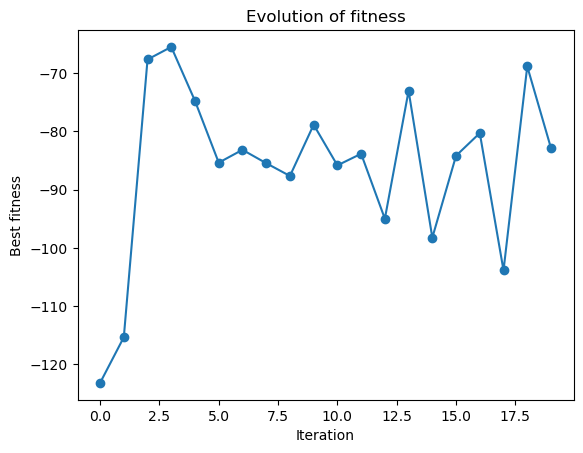

In [21]:
#----------test---------
env = gym.make(
    "LunarLander-v3",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    #render_mode="human", # None for intensive simulation
)

iterations = 20 #pop_size==iterations ? 400-500
pop_size = 40    #prendre 80 
n_sim = 5 #10
tsize = 3               
mutation_rate = 0.5    
mutation_strength = 0.02
            

best_model, best_scores = genetic_algorithm(iterations, pop_size, tsize, mutation_rate, mutation_strength, n_sim, env)
    
env.close()

plt.plot(best_scores, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best fitness")
plt.title("Evolution of fitness")
plt.show()

In [22]:
env = gym.make(
    "LunarLander-v3",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
    render_mode="human", # None for intensive simulation
)

run(best_model[-1], env, 5)
    
env.close()